In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.datasets import make_classification

In [2]:
# Generate a classification dataset with a binary target
X, y = make_classification(n_samples=100, n_features=3, n_informative=2, n_redundant=0, n_classes=2, random_state=42)

# Convert to DataFrame
df = pd.DataFrame(X, columns=['feature_1', 'feature_2', 'feature_3'])
df['target'] = y

In [3]:
df = pd.read_csv('car_insurance.csv')
df.dropna(inplace = True)

In [4]:
# Display the first few rows of the dataset
df.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


--------------

Differences between ols and logistic regression using classification dataset

Intercept        -0.04343
annual_mileage    0.00003
dtype: float64


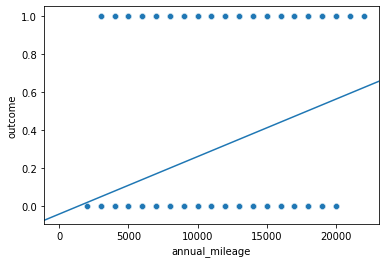

In [5]:
mdl = ols("outcome ~ annual_mileage", data=df).fit()
print(mdl.params)
intercept, slope = mdl.params
sns.scatterplot(x="annual_mileage",
                y="outcome",
                data=df)
plt.axline(xy1=(0, intercept),
          slope=slope)
plt.show()

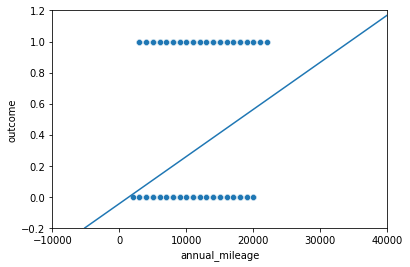

In [6]:
sns.scatterplot(x="annual_mileage",
                y="outcome",
                data=df)
plt.axline(xy1=(0,intercept),
           slope=slope)
plt.xlim(-10000, 40000)
plt.ylim(-0.2, 1.2)
plt.show()

you can see the regression line going to negative probabilities, which is impossible (solution next)

In [7]:
mdl_logit = logit("outcome ~ annual_mileage", data=df).fit()
print(mdl_logit.params)

Optimization terminated successfully.
         Current function value: 0.602726
         Iterations 5
Intercept        -2.530382
annual_mileage    0.000146
dtype: float64


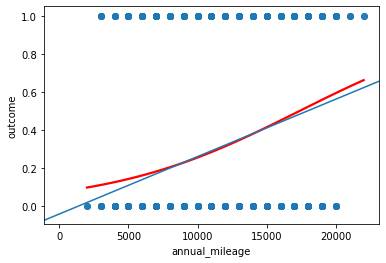

In [8]:
sns.regplot(x="annual_mileage",
            y="outcome",
            data=df,
            ci=None,
            line_kws={"color": "red"}, # the colour of the trend line
            logistic=True) # for logistic regression
plt.axline(xy1=(0, intercept),
          slope=slope)
plt.show()

With logistic regression, the trend line never becomes above 1 or negative

### Prediction with logistic regression

Optimization terminated successfully.
         Current function value: 0.602726
         Iterations 5


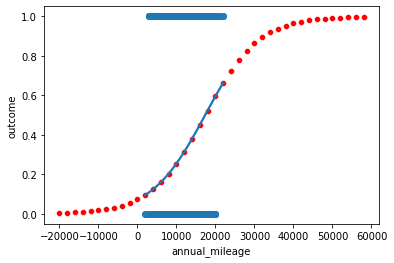

In [9]:
mdl_recency = logit("outcome ~ annual_mileage",
                    data = df).fit()

explanatory_data = pd.DataFrame(
  {"annual_mileage": np.arange(-20000, 60000, 2000)})

prediction_data = explanatory_data.assign(    
  outcome = mdl_recency.predict(explanatory_data))

# Adding point predictions
sns.regplot(x="annual_mileage",
            y="outcome",
            data=df,
            ci=None,
            logistic=True)

sns.scatterplot(x="annual_mileage", # add the prediction data with red colour
                y="outcome",
                data=prediction_data,
                color="red")
plt.show()

#### The prediction following the trend line

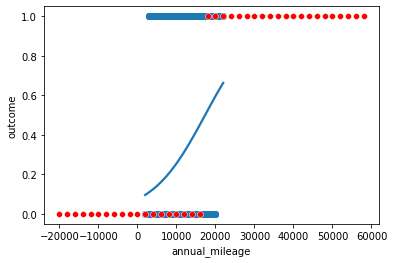

In [10]:
# Round the prediction output that means more than 0.5 -> 1, less 0.5 -> 0, because the churn is 0 or 1
prediction_data = explanatory_data.assign(
              outcome = mdl_recency.predict(explanatory_data))
prediction_data["most_likely_outcome"] = np.round(prediction_data["outcome"])

# Visualizing the most likely outcome - the new prediction 
sns.regplot(x="annual_mileage",
            y="outcome",       
            data=df,        
            ci=None,        
            logistic=True)

sns.scatterplot(x="annual_mileage", # add the most likely prediction data with red colour
                y="most_likely_outcome",       
                data=prediction_data,        
                color="red")
plt.show()

Prediction Data


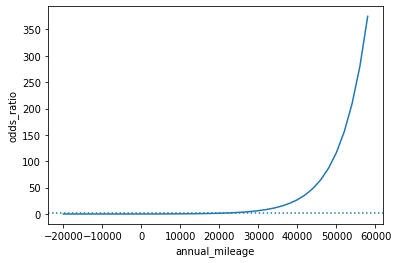

Prediction Data with Log Scale


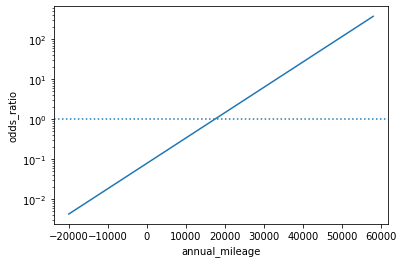

In [11]:
prediction_data["odds_ratio"] = prediction_data["outcome"] / (1 - prediction_data["outcome"])

print('Prediction Data')
# Visualizing odds ratio
sns.lineplot(x="annual_mileage",  
             y="odds_ratio",        
             data=prediction_data)

plt.axhline(y=1,      
            linestyle="dotted")
plt.show()

print('Prediction Data with Log Scale')
# Visualizing log odds ratio
sns.lineplot(x="annual_mileage",      
             y="odds_ratio",         
             data=prediction_data)
plt.axhline(y=1,        
            linestyle="dotted")
plt.yscale("log")
plt.show()

### How efficient is the predicted data

In [12]:
# Confusion matrix: counts of outcomes
actual_response = df["outcome"]

predicted_response = np.round(mdl_recency.predict()) # getting from the previous model

outcomes = pd.DataFrame({"outcome": actual_response,
                         "predicted_response": predicted_response})
print(outcomes.value_counts(sort=False))

outcome  predicted_response
0.0      0.0                   5552
         1.0                     61
1.0      0.0                   2443
         1.0                     93
dtype: int64


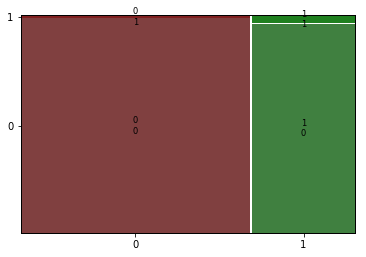

In [13]:
conf_matrix = mdl_recency.pred_table()

mosaic(conf_matrix)
plt.show()

### Evaluate other measures

In [14]:
TN = conf_matrix[0,0]
TP = conf_matrix[1,1]
FN = conf_matrix[1,0]
FP = conf_matrix[0,1]

----------------

#### Accuracy is the proportion of correct predictions.

Higher is better

In [15]:
acc = (TN + TP) / (TN + TP + FN + FP)
print(acc)

0.692723033501043


-----------------------

#### Sensitivity is the proportion of true positives.

Higher is better

In [16]:
sens = TP / (FN + TP)
print(sens)

0.03667192429022082


---

#### Specicity is the proportion of true negatives.

Higher is better

In [17]:
spec = TN / (TN + FP)
print(spec)

0.9891323712809549


---
#### where improving specificity will decrease sensitivity, or increasing sensitivity will decrease specificity.